In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
import utils
import indep_sites

import pickle
import glob
from math import ceil, sqrt, floor
import random
from pathlib import Path 

File names for data

In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))

In [3]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [113]:
sequences_all = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_ids];

## Extract sequences and compute 1st and 2nd moment statistics, write to files

In [114]:
ps_small = np.logspace(-8,-1.5,10)
ps_large = 1 - ps_small
ps_spaced = np.linspace(0, 0.95, 20)
pseudocounts = np.concatenate((ps_small, ps_large, ps_spaced))
pseudocounts = np.round(pseudocounts, decimals=8)
pseudocounts.sort()
pseudocounts

array([0.0000000e+00, 1.0000000e-08, 5.0000000e-08, 2.8000000e-07,
       1.4700000e-06, 7.7400000e-06, 4.0840000e-05, 2.1544000e-04,
       1.1364600e-03, 5.9948400e-03, 3.1622780e-02, 5.0000000e-02,
       1.0000000e-01, 1.5000000e-01, 2.0000000e-01, 2.5000000e-01,
       3.0000000e-01, 3.5000000e-01, 4.0000000e-01, 4.5000000e-01,
       5.0000000e-01, 5.5000000e-01, 6.0000000e-01, 6.5000000e-01,
       7.0000000e-01, 7.5000000e-01, 8.0000000e-01, 8.5000000e-01,
       9.0000000e-01, 9.5000000e-01, 9.6837722e-01, 9.9400516e-01,
       9.9886354e-01, 9.9978456e-01, 9.9995916e-01, 9.9999226e-01,
       9.9999853e-01, 9.9999972e-01, 9.9999995e-01, 9.9999999e-01])

In [115]:
ls_s = [format(x, '.8f') for x in pseudocounts]
' '.join(ls_s)

'0.00000000 0.00000001 0.00000005 0.00000028 0.00000147 0.00000774 0.00004084 0.00021544 0.00113646 0.00599484 0.03162278 0.05000000 0.10000000 0.15000000 0.20000000 0.25000000 0.30000000 0.35000000 0.40000000 0.45000000 0.50000000 0.55000000 0.60000000 0.65000000 0.70000000 0.75000000 0.80000000 0.85000000 0.90000000 0.95000000 0.96837722 0.99400516 0.99886354 0.99978456 0.99995916 0.99999226 0.99999853 0.99999972 0.99999995 0.99999999'

In [28]:
import importlib
importlib.reload(utils)
importlib.reload(indep_sites)

<module 'indep_sites' from '/home/scrotti/Aptamer2025py/experiments/../indep_sites.py'>

In [ ]:
for n in range(len(sequences_all)):   
    print("Dataset " + str(n) + " started...")
    experiment_id = experiment_ids[n]
    sequences_oh = [adabmDCA.functional.one_hot(seq, num_classes=4).to(dtype) for seq in sequences_all[n]]
    for pseudocount in pseudocounts:
        freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
            *[utils.frequences_from_sequences_oh(seq, pseudo_count=pseudocount) 
              for seq in sequences_oh])
        fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
        fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
        total_reads = torch.tensor(total_reads_tuple)
    
        pc_str = format(pseudocount, '.8f')
        
        filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
        filepath = "saved/freq_pseudocount/" + filename
        
        data = [fi, fij, total_reads]
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

# Read

## Read parameters of trained models from all three datasets

In [118]:
data = []

for n in ns:
    data.append([])
    dir = './saved/pseudocount/indep_sites/'
    for filepath in sorted(glob.iglob(dir + experiment_ids[n]+'*.pkl')):
        with open(filepath, 'rb') as f:
            data[-1].append(pickle.load(f))
    print(f"Dataset f{experiment_ids[n]}. Loaded {len(data[-1])} files.")

experiment_id_all, round_ids_all, params_all, pseudocount_all = zip(*[
    zip(*d) for d in data])

for n in ns:
    assert((sorted(np.array(pseudocount_all[n])) == np.array(pseudocount_all[n])).all())
    assert((np.array(experiment_id_all[n]) == experiment_ids[n]).all())

Dataset fDop8V030. Loaded 40 files.
Dataset fDop8V930. Loaded 40 files.
Dataset fDop8V2430. Loaded 40 files.


In [143]:
params_zerosum_all = [[utils.set_zerosum_gauge(params_all[n][a])
                        for a in pc_idx] for n in ns]
params_all = params_zerosum_all

In [144]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

wts_oh = [adabmDCA.functional.one_hot(wts[n][None,:]) for n in ns]

In [35]:
pc_idx = range(len(pseudocount_all[0]))

In [38]:
sequences_unique_all = [[torch.unique(seq_t, dim=0) for seq_t in sequences_all[n]] for n in ns]
sequences_unique_oh_all = [[adabmDCA.functional.one_hot(s) for s in sequences_unique_all[n]] for n in ns]

In [40]:
# params_t_all = [[[utils.set_zerosum_gauge(indep_sites.get_params_at_round(params_all[n][a], t))
                  # for t in ts] for a in pc_idx] for n in ns]

In [162]:
import gc

def run_and_save(n, a, N):
    print(f'Starting dataset {n}, pseudocount {a}...')
    
    pc = pseudocounts[a]
    # Compute logNst of sequences in dataset n with parameters learned from dataset n, except use the Ns0
    #  learned from dataset n
    logNst_n = [[-indep_sites.compute_energy(
                                            sequences_unique_oh_all[n][t], 
                                            indep_sites.get_params_at_round(params_all[m][a], t, params_Ns0=params_all[n][a]))
                   for t in ts] for m in ns]

    pearsons_n = [[torch.corrcoef(torch.stack((logNst_n[m][t], logNst_n[n][t])))[0,1] 
               for t in ts] for m in ns]

    idx = [random.sample(range(len(logNst_n[0][t])), min(N,len(logNst_n[0][t])))  for t in ts]
    X_n, Y_n = zip(*[zip(*[(logNst_n[m][t][idx[t]], logNst_n[n][t][idx[t]]) for t in ts]) for m in ns])
    
    filename = experiment_ids[n] + "_pseudocount_" + format(pc, ".8f") + ".pkl"
    filepath = "saved/plot_Nst_pseudocount_indep_sites/" + filename
    
    data = [pearsons_n, X_n, Y_n]
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

    gc.collect()

In [163]:
N = 5*10**4

for n in ns:
    for a in pc_idx:
        run_and_save(n, a, N)

Starting dataset 0, pseudocount 0...
Starting dataset 0, pseudocount 1...
Starting dataset 0, pseudocount 2...
Starting dataset 0, pseudocount 3...
Starting dataset 0, pseudocount 4...
Starting dataset 0, pseudocount 5...
Starting dataset 0, pseudocount 6...
Starting dataset 0, pseudocount 7...
Starting dataset 0, pseudocount 8...
Starting dataset 0, pseudocount 9...
Starting dataset 0, pseudocount 10...
Starting dataset 0, pseudocount 11...
Starting dataset 0, pseudocount 12...
Starting dataset 0, pseudocount 13...
Starting dataset 0, pseudocount 14...
Starting dataset 0, pseudocount 15...
Starting dataset 0, pseudocount 16...
Starting dataset 0, pseudocount 17...
Starting dataset 0, pseudocount 18...
Starting dataset 0, pseudocount 19...
Starting dataset 0, pseudocount 20...
Starting dataset 0, pseudocount 21...
Starting dataset 0, pseudocount 22...
Starting dataset 0, pseudocount 23...
Starting dataset 0, pseudocount 24...
Starting dataset 0, pseudocount 25...
Starting dataset 0, ps

In [164]:
data = []

for n in ns:
    data_n = []
    print("loading dataset " + str(n))
    for filepath in sorted(glob.iglob('./saved/plot_Nst_pseudocount_indep_sites/*.pkl')):
        if Path(filepath).name.startswith(experiment_ids[n]):
            with open(filepath, 'rb') as f:
                data_n.append(pickle.load(f))
    data.append(zip(*data_n))

print(f"Loaded {len(data)} files.")

pearsons, X, Y = zip(*data)

loading dataset 0
loading dataset 1
loading dataset 2
Loaded 3 files.


In [165]:
pc_idx_reduced = range(25,40)
pc_idx_reduced = range(15)
pc_idx_reduced = pc_idx

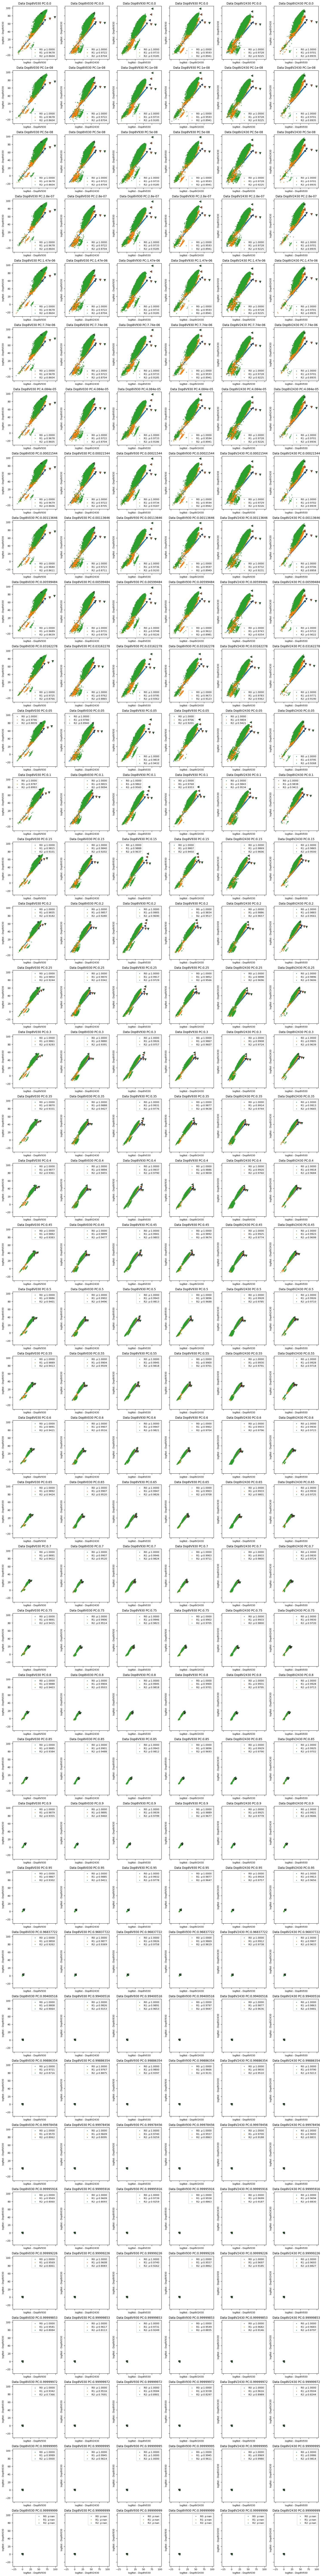

In [166]:
n_pc = len(pc_idx_reduced)
fig, axes = plt.subplots(n_pc, 6, figsize=(15,3*n_pc), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=8) 

for i in range(n_pc):
    a = pc_idx_reduced[i]
    j = -1
    for m in ns:
        for n in ns:
            if m != n:
                j += 1
                ax = axes[i,j]
                for t in ts:
                    ax.scatter(X[n][a][m][t], Y[n][a][m][t], label=f"R{t}: ρ:{pearsons[n][a][m][t]:.{4}f}", 
                               s=2, color=colors[t])
                    ax.set_xlabel(f"logNst - {experiment_ids[n]}")
                    ax.set_ylabel(f"logNst - {experiment_ids[m]}")
                    ax.set_title(f"Data {experiment_ids[m]} PC:{pseudocounts[a]}")
                    ## plot wildtypes
                    x = -indep_sites.compute_energy(wts_oh[n], 
                        indep_sites.get_params_at_round(params_all[n][a], t, params_Ns0=params_all[n][a]))
                    y = -indep_sites.compute_energy(wts_oh[n], 
                        indep_sites.get_params_at_round(params_all[m][a], t, params_Ns0=params_all[n][a]))
                    ax.scatter(x, y, marker='v', edgecolor='black', color=colors[t])
                    x = -indep_sites.compute_energy(wts_oh[m], 
                        indep_sites.get_params_at_round(params_all[n][a], t, params_Ns0=params_all[m][a]))
                    y = -indep_sites.compute_energy(wts_oh[m], 
                        indep_sites.get_params_at_round(params_all[m][a], t, params_Ns0=params_all[m][a]))
                    ax.scatter(x, y, marker='<', edgecolor='black', color=colors[t])
                ax.legend()
plt.tight_layout()
plt.savefig('img/logNst_cross_pseudocount_indep_sites.png')

## log ps

In [167]:
params_ps_all = [[indep_sites.get_params_ps(params_all[n][a]) for a in pc_idx] for n in ns]

In [175]:
import gc

def run_and_save_ps(n, a, N):
    print(f'Starting dataset {n}, pseudocount {a}...')
    
    pc = pseudocounts[a]
    logps_n = [[-indep_sites.compute_energy(
                                            sequences_unique_oh_all[n][t], 
                                            params_ps_all[m][a])
                   for t in ts] for m in ns]

    pearsons_n = [[torch.corrcoef(torch.stack((logps_n[m][t], logps_n[n][t])))[0,1] 
               for t in ts] for m in ns]

    idx = [random.sample(range(len(logps_n[0][t])), min(N,len(logps_n[0][t])))  for t in ts]
    X_n, Y_n = zip(*[zip(*[(logps_n[m][t][idx[t]], logps_n[n][t][idx[t]]) for t in ts]) for m in ns])
    
    filename = experiment_ids[n] + "_pseudocount_" + format(pc, ".8f") + ".pkl"
    filepath = "saved/plot_ps_pseudocount_indep_sites/" + filename
    
    data = [pearsons_n, X_n, Y_n]
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

    gc.collect()

In [176]:
N = 5*10**4

for n in ns:
    for a in pc_idx:
        run_and_save_ps(n, a, N)

Starting dataset 0, pseudocount 0...
Starting dataset 0, pseudocount 1...
Starting dataset 0, pseudocount 2...
Starting dataset 0, pseudocount 3...
Starting dataset 0, pseudocount 4...
Starting dataset 0, pseudocount 5...
Starting dataset 0, pseudocount 6...
Starting dataset 0, pseudocount 7...
Starting dataset 0, pseudocount 8...
Starting dataset 0, pseudocount 9...
Starting dataset 0, pseudocount 10...
Starting dataset 0, pseudocount 11...
Starting dataset 0, pseudocount 12...
Starting dataset 0, pseudocount 13...
Starting dataset 0, pseudocount 14...
Starting dataset 0, pseudocount 15...
Starting dataset 0, pseudocount 16...
Starting dataset 0, pseudocount 17...
Starting dataset 0, pseudocount 18...
Starting dataset 0, pseudocount 19...
Starting dataset 0, pseudocount 20...
Starting dataset 0, pseudocount 21...
Starting dataset 0, pseudocount 22...
Starting dataset 0, pseudocount 23...
Starting dataset 0, pseudocount 24...
Starting dataset 0, pseudocount 25...
Starting dataset 0, ps

In [177]:
data = []

for n in ns:
    data_n = []
    print("loading dataset " + str(n))
    for filepath in sorted(glob.iglob('./saved/plot_ps_pseudocount_indep_sites/*.pkl')):
        if Path(filepath).name.startswith(experiment_ids[n]):
            with open(filepath, 'rb') as f:
                data_n.append(pickle.load(f))
    data.append(zip(*data_n))

print(f"Loaded {len(data)} files.")

pearsons_ps, X_ps, Y_ps = zip(*data)

loading dataset 0
loading dataset 1
loading dataset 2
Loaded 3 files.


In [178]:
pc_idx_reduced = range(25,40)
pc_idx_reduced = range(15)
pc_idx_reduced = pc_idx

In [ ]:
n_pc = len(pc_idx_reduced)
fig, axes = plt.subplots(n_pc, 6, figsize=(15,3*n_pc), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=8) 

for i in range(n_pc):
    a = pc_idx_reduced[i]
    j = -1
    for m in ns:
        for n in ns:
            if m != n:
                j += 1
                ax = axes[i,j]
                for t in ts:
                    ax.scatter(X_ps[n][a][m][t], Y_ps[n][a][m][t], 
                               label=f"R{t}: ρ:{pearsons_ps[n][a][m][t]:.{4}f}", 
                               s=2, color=colors[t])
                    ax.set_xlabel(f"logps - {experiment_ids[n]}")
                    ax.set_ylabel(f"logps - {experiment_ids[m]}")
                    ax.set_title(f"Data {experiment_ids[m]} PC:{pseudocounts[a]}")
                ## plot wildtypes
                x = -indep_sites.compute_energy(wts_oh[n], params_ps_all[n][a])
                y = -indep_sites.compute_energy(wts_oh[n], params_ps_all[m][a])
                ax.scatter(x, y, marker='v', edgecolor='black')
                x = -indep_sites.compute_energy(wts_oh[m], params_ps_all[n][a])
                y = -indep_sites.compute_energy(wts_oh[m], params_ps_all[m][a])
                ax.scatter(x, y, marker='<', edgecolor='black')
                ax.legend()
plt.tight_layout()
plt.savefig('img/logps_cross_pseudocount_indep_sites.png')

In [12]:
logps_cross = [[[[-adabmDCA.statmech.compute_energy(
    sequences_unique_oh_all[m][t], params_ps_all[n][a]) 
              for t in ts] for a in pc_idx] for n in ns] for m in ns]

In [25]:
logps_wt_cross = [[[-adabmDCA.statmech.compute_energy(wts_oh[m], params_ps_all[n][a]) 
                    for a in pc_idx] for n in ns] for m in ns]

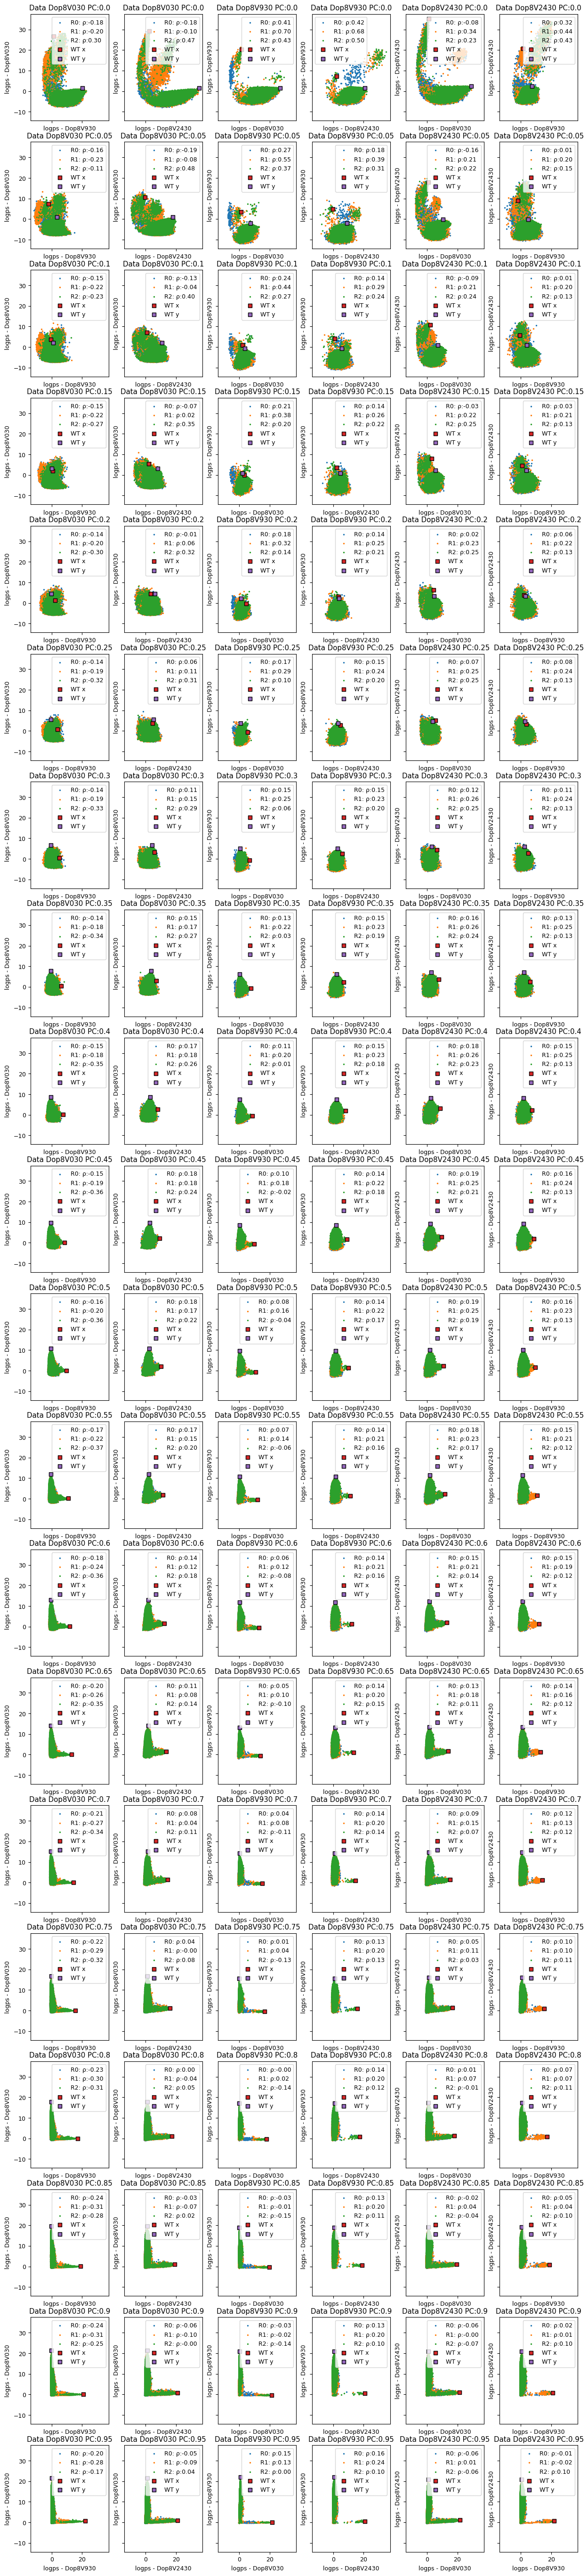

In [31]:
N = 10**5

fig, axes = plt.subplots(len(pc_idx), 6, figsize=(15,3.5*len(pc_idx)), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

for a in pc_idx:
    j = -1
    for m in ns:
        for n in ns:
            if m != n:
                j += 1
                ax = axes[a,j]
                for t in ts:
                    x = logps_cross[m][n][a][t]
                    y = logps_cross[m][m][a][t]
                    pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                    idx = random.sample(range(len(x)),min(N, len(x)))
                    ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                    ax.set_xlabel(f"logps - {experiment_ids[n]}")
                    ax.set_ylabel(f"logps - {experiment_ids[m]}")
                    ax.set_title(f"Data {experiment_ids[m]} PC:{pseudocount_all[n][a]}")
                ax.scatter(logps_wt_cross[n][n][a], logps_wt_cross[n][m][a], marker='s',
                           edgecolor='black', label="WT x", color=colors[3])
                ax.scatter(logps_wt_cross[m][n][a], logps_wt_cross[m][m][a], marker='s',
                           edgecolor='black', label="WT y", color=colors[4])
                ax.legend()
    # plt.tight_layout()
plt.savefig('img/logps_cross_pseudocount.png')

In [49]:
import numpy as np

a = pseudocount_all.argsort()[-1]

h = params_all[a]["bias_ps"].reshape(-1)
J = params_all[a]["couplings_ps"].reshape(45*4, 45*4)

# eigs = np.linalg.eig(J)
# lambdaJ = eigs.eigenvalues
# vJ = eigs.eigenvectors
# # plt.plot(abs(lambdaJ))
# vJ[:,0].reshape(45, 4)
F = torch.sqrt(params_all[a]["couplings_ps"].sum(dim=(1,3))**2)
plt.imshow(F)
plt.colorbar()

NameError: name 'pseudocount_all' is not defined

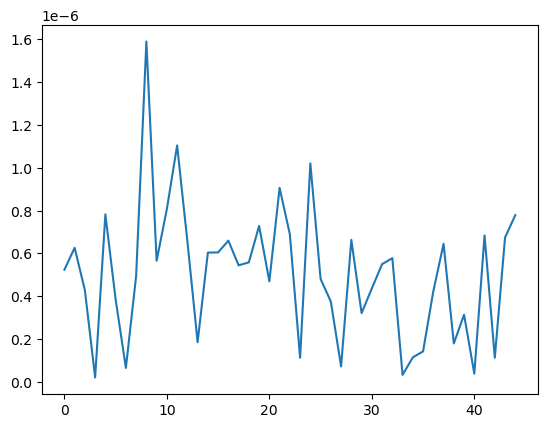

In [240]:
plt.plot(torch.sqrt(params_all[a]["bias_ps"].sum(dim=1)**2))

In [175]:
a = pseudocount_all.argsort()[-1]

n = 1
X = logps_x[a][n]
Y = logps_y[a][n]

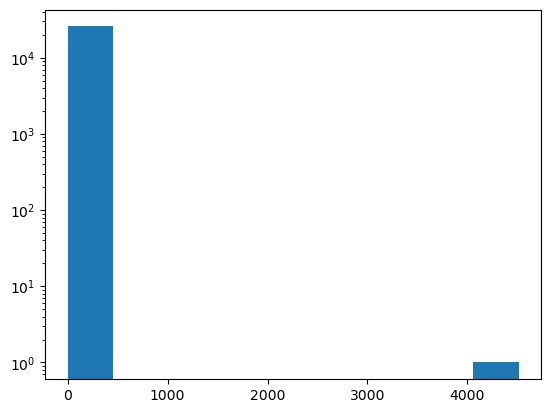

In [198]:
t = 2

id = (X[t] > 15) * (Y[t] > 15)
plt.hist(counts_others[n][t][id])
plt.yscale('log')

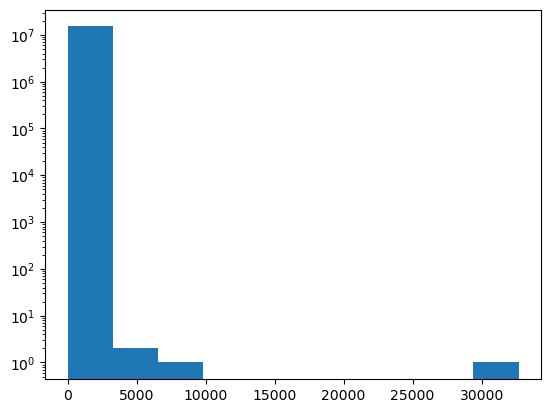

In [199]:
plt.hist(counts_others[n][t])
plt.yscale('log')